# Chapter 5

This is the fifth in a series of notebooks related to astronomy data.

As a continuing example, we will replicate part of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

Picking up where we left off, the next step in the analysis is to select candidate stars based on photometry.  The following figure from the paper is a color-magnitude diagram for the stars selected based on proper motion:

<img width="300" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-3.png">

In red is a theoretical isochrone, showing where we expect the stars in GD-1 to fall based on the metallicity and age of their original globular cluster. 

By selecting stars in the shaded area, we can further distinguish the main sequence of GD-1 from younger background stars.

## Outline

Here are the steps in this notebook:

1. We'll reload the candidate stars we identified in the previous notebook.

2. Then we'll run a query on the Gaia server that uploads the table of candidates and uses a `JOIN` operation to select photometry data for the candidate stars.

3. We'll write the results to a file for use in the next notebook.

After completing this lesson, you should be able to

* Upload a table to the Gaia server.

* Write ADQL queries involving `JOIN` operations.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and a the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  

If you are using this notebook as part of a Carpentries workshop, you should have received setup instructions.

TODO: Add a link to the instructions.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia python-wget

## Reloading the data

The following cell downloads the data from the previous notebook.

In [2]:
import os
from wget import download

filename = 'gd1_candidates.hdf5'
path = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(path+filename))

And we can read it back.

In [3]:
import pandas as pd

candidate_df = pd.read_hdf(filename, 'candidate_df')

`candidate_df` is the Pandas DataFrame that contains results from the query in the previous notebook, which selects stars likely to be in GD-1 based on proper motion.  It also includes position and proper motion transformed to the ICRS frame.

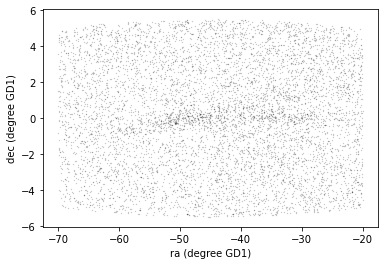

In [4]:
import matplotlib.pyplot as plt

x = candidate_df['phi1']
y = candidate_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

This is the same figure we saw at the end of the previous notebook.  GD-1 is visible against the background stars, but we will be able to see it more clearly after selecting based on photometry data.

## Getting photometry data

The Gaia dataset contains some photometry data, including the variable `bp_rp`, which we used in the original query to select stars with BP - RP color between -0.75 and 2.

Selecting stars with `bp-rp` less than 2 excludes many class M dwarf stars, which are low temperature, low luminosity.  A star like that at GD-1's distance would be hard to detect, so if it is detected, it it more likely to be in the foreground.

Now, to select stars with the age and metal richness we expect in GD-1, we will use `g - i` color and apparent `g`-band magnitude, which are available from the Pan-STARRS survey.

Conveniently, the Gaia server provides data from Pan-STARRS as a table in the same database we have been using, so we can access it by making ADQL queries.

In general, looking up a star from the Gaia catalog and finding the corresponding star in the Pan-STARRS catalog is not easy.  This kind of cross matching is not always possible, because a star might appear in one catalog and not the other.  And even when both stars are present, there might not be a clear one-to-one relationship between stars in the two catalogs.

Fortunately, smart people have worked on this problem, and the Gaia database includes cross-matching tables that suggest a best neighbor in the Pan-STARRS catalog for many stars in the Gaia catalog.

[This document describes the cross matching process](https://gea.esac.esa.int/archive/documentation/GDR2/Catalogue_consolidation/chap_cu9val_cu9val/ssec_cu9xma/sssec_cu9xma_extcat.html).  Briefly, it uses a cone search to find possible matches in approximately the right position, then uses attributes like color and magnitude to choose pairs of stars most likely to be identical.

So the hard part of cross-matching has been done for us.  However, using the results is a little tricky.

But, it is also an opportunity to learn about one of the most important tools for working with databases: "joining" tables.

In general, a "join" is an operation where you match up records from one table with records from another table using as a "key" a piece of information that is common to both tables, usually some kind of ID code.

In this example:

* Stars in the Gaia dataset are identified by `source_id`.

* Stars in the Pan-STARRS dataset are identified by `obj_id`.

For each candidate star we have selected so far, we have the `source_id`; the goal is to find the `obj_id` for the same star (we hope) in the Pan-STARRS catalog.

To do that we will:

1. Make a table that contains the `source_id` for each candidate star and upload the table to the Gaia server;

2. Use the `JOIN` operator to look up each `source_id` in the `gaiadr2.panstarrs1_best_neighbour` table, which contains the `obj_id` of the best match for each star in the Gaia catalog; then

3. Use the `JOIN` operator again to look up each `obj_id` in the `panstarrs1_original_valid` table, which contains the Pan-STARRS photometry data we want.

Let's start with the first step, uploading a table.

## Preparing a table for uploading

For each candidate star, we want to find the corresponding row in the `gaiadr2.panstarrs1_best_neighbour` table.

In order to do that, we have to:

1. Write the table in a local file as an XML VOTable, which is a format suitable for transmitting a table over a network.

2. Write an ADQL query that refers to the uploaded table.

3. Change the way we submit the job so it uploads the table before running the query.

The first step is not too difficult because Astropy provides a function called `writeto` that can write a `Table` in `XML`.

[The documentation of this process is here](https://docs.astropy.org/en/stable/io/votable/).

First we have to convert our Pandas `DataFrame` to an Astropy `Table`.

In [5]:
from astropy.table import Table

candidate_table = Table.from_pandas(candidate_df)
type(candidate_table)

astropy.table.table.Table

To write the file, we can use `Table.write` with `format='votable'`, [as described here](https://docs.astropy.org/en/stable/io/unified.html#vo-tables).

In [6]:
table = candidate_table[['source_id']]
table.write('candidate_df.xml', format='votable', overwrite=True)

Notice that we select a single column from the table, `source_id`.
We could write the entire table to a file, but that would take longer to transmit over the network, and we really only need one column.

This process, taking a structure like a `Table` and translating it into a form that can be transmitted over a network, is called [serialization](https://en.wikipedia.org/wiki/Serialization).

XML is one of the most common serialization formats.  One nice feature is that XML data is plain text, as opposed to binary digits, so you can read the file we just wrote:

In [7]:
!head candidate_df.xml

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 4.0.1.post1
     http://www.astropy.org/ -->
<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="source_id" datatype="long" name="source_id"/>
   <DATA>
    <TABLEDATA>
     <TR>


XML is a general format, so different XML files contain different kinds of data.  In order to read an XML file, it's not enough to know that it's XML; you also have to know the data format, which is called a [schema](https://en.wikipedia.org/wiki/XML_schema).

In this example, the schema is VOTable; notice that one of the first tags in the file specifies the schema, and even includes the URL where you can get its definition.

So this is an example of a self-documenting format.

A drawback of XML is that it tends to be big, which is why we wrote just the `source_id` column rather than the whole table.
The size of the file is about 750 KB, so that's not too bad.

In [8]:
!ls -lh candidate_df.xml

-rw-rw-r-- 1 downey downey 396K Oct 19 14:48 candidate_df.xml


If you are using Windows, `ls` might not work; in that case, try:

```
!dir candidate_df.xml
```

**Exercise:** There's a gotcha here we want to warn you about.  Why do you think we used double brackets to specify the column we wanted?  What happens if you use single brackets?

Run these cells to find out.

In [9]:
table = candidate_table[['source_id']]
type(table)

astropy.table.table.Table

In [10]:
column = candidate_table['source_id']
type(column)

astropy.table.column.Column

In [11]:
# writeto(column, 'candidate_df.xml')

## Uploading a table

The next step is to upload this table to the Gaia server and use it as part of a query.

[Here's the documentation that explains how to run a query with an uploaded table](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html#synchronous-query-on-an-on-the-fly-uploaded-table).

In the spirit of incremental development and testing, let's start with the simplest possible query.

In [12]:
query = """SELECT *
FROM tap_upload.candidate_df
"""

This query downloads all rows and all columns from the uploaded table.  The name of the table has two parts: `tap_upload` specifies a table that was uploaded using TAP+ (remember that's the name of the protocol we're using to talk to the Gaia server).

And `candidate_df` is the name of the table, which we get to choose (unlike `tap_upload`, which we didn't get to choose).

Here's how we run the query:

In [13]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query=query, 
                            upload_resource='candidate_df.xml', 
                            upload_table_name='candidate_df')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]


`upload_resource` specifies the name of the file we want to upload, which is the file we just wrote.

`upload_table_name` is the name we assign to this table, which is the name we used in the query.

And here are the results:

In [14]:
results = job.get_results()
results

source_id
int64
635559124339440000
635860218726658176
635674126383965568
635535454774983040
635497276810313600
635614168640132864
635821843194387840
635551706931167104
635518889086133376


If things go according to plan, the result should contain the same rows and columns as the uploaded table.

In [15]:
len(candidate_table), len(results)

(7346, 7346)

In [16]:
set(candidate_table['source_id']) == set(results['source_id'])

True

In this example, we uploaded a table and then downloaded it again, so that's not too useful.

But now that we can upload a table, we can join it with other tables on the Gaia server.

## Joining with an uploaded table

Here's the first example of a query that contains a `JOIN` clause.

In [17]:
query1 = """SELECT *
FROM gaiadr2.panstarrs1_best_neighbour as best
JOIN tap_upload.candidate_df as candidate_df
ON best.source_id = candidate_df.source_id
"""

Let's break that down one clause at a time:

* `SELECT *` means we will download all columns from both tables.

* `FROM gaiadr2.panstarrs1_best_neighbour as best` means that we'll get the columns from the Pan-STARRS best neighbor table, which we'll refer to using the short name `best`.

* `JOIN tap_upload.candidate_df as candidate_df` means that we'll also get columns from the uploaded table, which we'll refer to using the short name `candidate_df`.

* `ON best.source_id = candidate_df.source_id` specifies that we will use `source_id ` to match up the rows from the two tables.

Here's the [documentation of the best neighbor table](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_crossmatches/ssec_dm_panstarrs1_best_neighbour.html).

Let's run the query:

In [18]:
job1 = Gaia.launch_job_async(query=query1, 
                       upload_resource='candidate_df.xml', 
                       upload_table_name='candidate_df')

INFO: Query finished. [astroquery.utils.tap.core]


And get the results.

In [19]:
results1 = job1.get_results()
results1

source_id,original_ext_source_id,angular_distance,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,gaia_astrometric_params,source_id_2
,,arcsec,,,,,
int64,int64,float64,int32,int16,int16,int16,int64
635860218726658176,130911385187671349,0.053667035895467084,1,0,1,5,635860218726658176
635674126383965568,130831388428488720,0.038810268141577516,1,0,1,5,635674126383965568
635535454774983040,130631378377657369,0.034323028828991076,1,0,1,5,635535454774983040
635497276810313600,130811380445631930,0.04720255413250006,1,0,1,5,635497276810313600
635614168640132864,130571395922140135,0.020304189709964143,1,0,1,5,635614168640132864
635598607974369792,130341392091279513,0.036524626853403054,1,0,1,5,635598607974369792
635737661835496576,131001399333502136,0.036626827820716606,1,0,1,5,635737661835496576
635850945892748672,132011398654934147,0.021178742393378396,1,0,1,5,635850945892748672


This table contains all of the columns from the best neighbor table, plus the single column from the uploaded table.

In [20]:
results1.colnames

['source_id',
 'original_ext_source_id',
 'angular_distance',
 'number_of_neighbours',
 'number_of_mates',
 'best_neighbour_multiplicity',
 'gaia_astrometric_params',
 'source_id_2']

Because one of the column names appears in both tables, the second instance of `source_id` has been appended with the suffix `_2`.

The length of the results table is about 2000, which means we were not able to find matches for all stars in the list of candidate_df.

In [21]:
len(results1)

3724

To get more information about the matching process, we can inspect `best_neighbour_multiplicity`, which indicates for each star in Gaia how many stars in Pan-STARRS are equally likely matches.

For this kind of data exploration, we'll convert a column from the table to a Pandas `Series` so we can use `value_counts`, which counts the number of times each value appears in a `Series`, like a histogram.

In [22]:
import pandas as pd

nn = pd.Series(results1['best_neighbour_multiplicity'])
nn.value_counts()

1    3724
dtype: int64

The result shows that `1` is the only value in the `Series`, appearing xxx times.

That means that in every case where a match was found, the matching algorithm identified a single neighbor as the most likely match.

Similarly, `number_of_mates` indicates the number of other stars in Gaia that match with the same star in Pan-STARRS.

In [23]:
nm = pd.Series(results1['number_of_mates'])
nm.value_counts()

0    3724
dtype: int64

For this set of candidate_df, almost all of the stars we've selected from Pan-STARRS are only matched with a single star in the Gaia catalog.

**Detail** The table also contains `number_of_neighbors` which is the number of stars in Pan-STARRS that match in terms of position, before using other critieria to choose the most likely match.

## Getting the photometry data

The most important column in `results1` is `original_ext_source_id` which is the `obj_id` we will use to look up the likely matches in Pan-STARRS to get photometry data.

The process is similar to what we just did to look up the matches.  We will:

1. Make a table that contains `source_id` and `original_ext_source_id`.

2. Write the table to an XML VOTable file.

3. Write a query that joins the uploaded table with `gaiadr2.panstarrs1_original_valid` and selects the photometry data we want.

4. Run the query using the uploaded table.

Since we've done everything here before, we'll do these steps as an exercise.

**Exercise:** Select `source_id` and `original_ext_source_id` from `results1` and write the resulting table as a file named `external.xml`.

In [24]:
# Solution

table = results1[['source_id', 'original_ext_source_id']]
table.write('external.xml', format='votable', overwrite=True)

Use `!head` to confirm that the file exists and contains an XML VOTable.

In [25]:
!head external.xml

<?xml version="1.0" encoding="utf-8"?>
<!-- Produced with astropy.io.votable version 4.0.1.post1
     http://www.astropy.org/ -->
<VOTABLE version="1.4" xmlns="http://www.ivoa.net/xml/VOTable/v1.4" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.ivoa.net/xml/VOTable/v1.4">
 <RESOURCE type="results">
  <TABLE>
   <FIELD ID="source_id" datatype="long" name="source_id" ucd="meta.id;meta.main">
    <DESCRIPTION>
     Unique Gaia source identifier
    </DESCRIPTION>


**Exercise:** Read [the documentation of the Pan-STARRS table](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_external_catalogues/ssec_dm_panstarrs1_original_valid.html) and make note of `obj_id`, which contains the object IDs we'll use to find the rows we want.

Write a query that uses each value of `original_ext_source_id` from the uploaded table to find a row in `gaiadr2.panstarrs1_original_valid` with the same value in `obj_id`, and select all columns from both tables.

Suggestion: Develop and test your query incrementally.  For example:

1. Write a query that downloads all columns from the uploaded table.  Test to make sure we can read the uploaded table.

2. Write a query that downloads the first 10 rows from `gaiadr2.panstarrs1_original_valid`.  Test to make sure we can access Pan-STARRS data.

3. Write a query that joins the two tables and selects all columns.  Test that the join works as expected.


As a bonus exercise, write a query that joins the two tables and selects just the columns we need:

* `source_id` from the uploaded table

* `g_mean_psf_mag` from `gaiadr2.panstarrs1_original_valid`

* `i_mean_psf_mag` from `gaiadr2.panstarrs1_original_valid`

Hint: When you select a column from a join, you have to specify which table the column is in.

In [26]:
# Solution

query2 = """SELECT *
FROM tap_upload.external as external
"""

In [27]:
# Solution

query2 = """SELECT TOP 10 *
FROM gaiadr2.panstarrs1_original_valid
"""

In [28]:
# Solution

query2 = """SELECT *
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id
"""

In [29]:
# Solution

query2 = """SELECT
external.source_id, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id
"""

In [30]:
print(query2)

SELECT
external.source_id, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid as ps
JOIN tap_upload.external as external
ON ps.obj_id = external.original_ext_source_id



In [31]:
job2 = Gaia.launch_job_async(query=query2, 
                       upload_resource='external.xml', 
                       upload_table_name='external')

INFO: Query finished. [astroquery.utils.tap.core]


In [32]:
results2 = job2.get_results()
results2

source_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
635860218726658176,17.8978004455566,17.5174007415771
635674126383965568,19.2873001098633,17.6781005859375
635535454774983040,16.9237995147705,16.478099822998
635497276810313600,19.9242000579834,18.3339996337891
635614168640132864,16.1515998840332,14.6662998199463
635598607974369792,16.5223999023438,16.1375007629395
635737661835496576,14.5032997131348,13.9849004745483
635850945892748672,16.5174999237061,16.0450000762939


**Challenge exercise**

Do both joins in one query.

There's an [example here](https://github.com/smoh/Getting-started-with-Gaia/blob/master/gaia-adql-snippets.md) you could start with.

## Write the data

Since we have the data in an Astropy `Table`, let's store it in a FITS file.

In [33]:
filename = 'gd1_photo.fits'
results2.write(filename, overwrite=True)

We can check that the file exists, and see how big it is.

In [34]:
!ls -lh gd1_photo.fits

-rw-rw-r-- 1 downey downey 96K Oct 19 14:49 gd1_photo.fits


At around 175 KB, it is smaller than some of the other files we've been working with.

If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_photo.fits
```

## Summary

In this notebook, we used database `JOIN` operations to select photometry data for the stars we've identified as candidates to be in GD-1.

In the next notebook, we'll use this data for a second round of selection, identifying stars that have photometry data consistent with GD-1.

## Best practice

* Use `JOIN` operations to combine data from multiple tables in a databased, using some kind of identifier to match up records from one table with records from another.

* This is another example of a practice we saw in the previous notebook, moving the computation to the data.